In [ ]:
# my own libraries
import prepare_data
import inspect_results as inspect
import explainability as explainer

# utils
import numpy as np
import pandas as pd
np.random.seed(7)
from numpy import loadtxt
import pickle
import tensorflow.keras as keras

# for visualization
import tikzplotlib
import matplotlib.pyplot as plt

# Explore data

Succesfully loaded PHM08 data from ../../Datasets/PHM08_Challenge_Data/train.txt
Succesfully calculated the CTFs (Cycles to Failure).
Succesfully calculated the RULs (Remaining Useful Lives).
Succesfully calculated the Heath States.


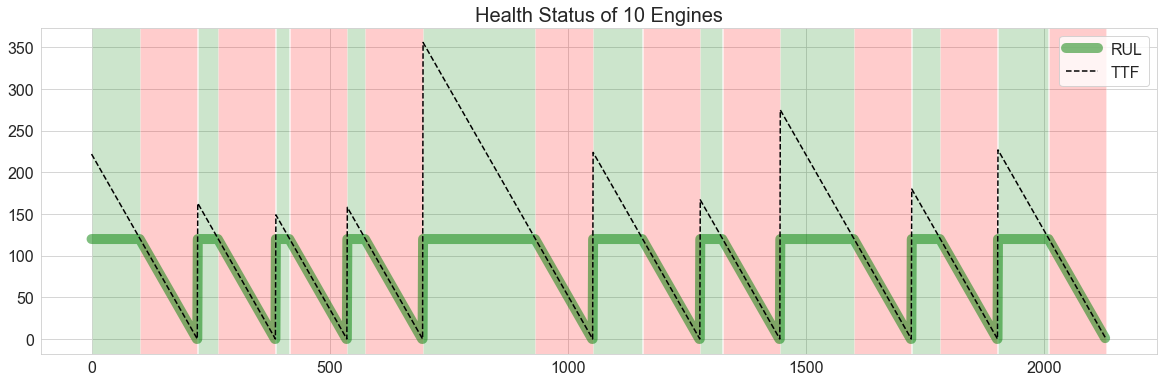

In [2]:
path = "../../Datasets/PHM08_Challenge_Data/train.txt"

cmapss = prepare_data.CMAPSS()

# not using the CMAPSS test set 
dev_mode = True 
dev_data = cmapss.load_data(path)

dev_data = cmapss.cluster_operational_settings(dev_data,
                                               dev_mode)
dev_data = cmapss.calculate_TTF(dev_data)
dev_data = cmapss.calculate_continues_healthstate(dev_data)
dev_data = cmapss.calculate_descrete_healthstate(dev_data)

# visualize this (maybe only an image)
cmapss.visualize_healthstatus(dev_data, 10)

In [3]:
len(dev_data)#[["unit", "cycle", "os_1", "os_2", "os_3", "s12"]].head(10)

45918

# explore the preprocessed data

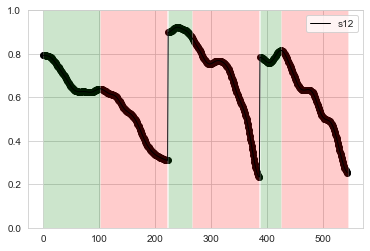

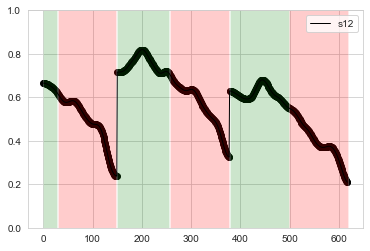

In [4]:
dev_data = cmapss.get_univariate_cmapss(dev_data, "s12")
x_train, x_test = cmapss.train_test_split(dev_data)
x_train = cmapss.minmax_scale(x_train)
x_train = cmapss.denoise_sensors(x_train)
cmapss.visualize_denoised_sensors(x_train, 3)

x_test = cmapss.minmax_scale(x_test)
x_test = cmapss.denoise_sensors(x_test)
cmapss.visualize_denoised_sensors(x_test, 3)

# Load train/test sets

In [5]:
x_train = loadtxt('results/x_train.csv', delimiter=',')
y_train = loadtxt('results/y_train.csv', delimiter=',')
x_test = loadtxt('results/x_test.csv', delimiter=',')
y_test = loadtxt('results/y_test.csv', delimiter=',')

In [6]:
len(x_train), len(x_test)

(3136, 1332)

# Load baselines


LogisticRegressionCV Classification Report:

              precision    recall  f1-score   support

         0.0       0.75      0.76      0.75       531
         1.0       0.84      0.83      0.83       801

    accuracy                           0.80      1332
   macro avg       0.79      0.79      0.79      1332
weighted avg       0.80      0.80      0.80      1332



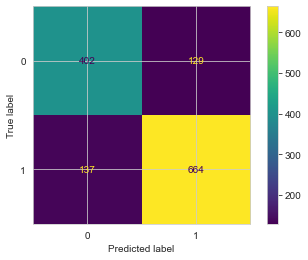


RidgeClassifierCV Classification Report:

              precision    recall  f1-score   support

         0.0       0.73      0.76      0.74       531
         1.0       0.83      0.81      0.82       801

    accuracy                           0.79      1332
   macro avg       0.78      0.79      0.78      1332
weighted avg       0.79      0.79      0.79      1332



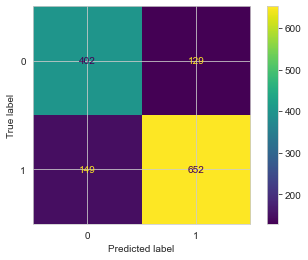


KNeighborsClassifier Classification Report:

              precision    recall  f1-score   support

         0.0       0.69      0.76      0.72       531
         1.0       0.83      0.78      0.80       801

    accuracy                           0.77      1332
   macro avg       0.76      0.77      0.76      1332
weighted avg       0.77      0.77      0.77      1332



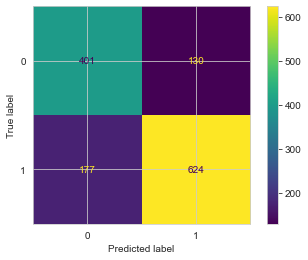


DecisionTreeClassifier Classification Report:

              precision    recall  f1-score   support

         0.0       0.73      0.71      0.72       531
         1.0       0.81      0.82      0.82       801

    accuracy                           0.78      1332
   macro avg       0.77      0.77      0.77      1332
weighted avg       0.78      0.78      0.78      1332



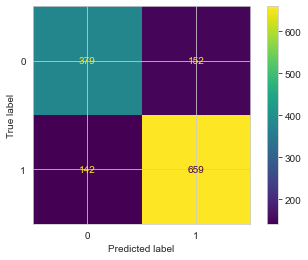

In [7]:
def report_baseline(model_name, x, y):
    with open('results/{}.pkl'.format(model_name), 'rb') as f:
        sk_model = pickle.load(f)
    f.close()

    y_pred = sk_model.predict(x)
    
    print('\n{} Classification Report:\n'.format(model_name))
    inspect.plot_classification_report(y, y_pred)

sk_models = ["LogisticRegressionCV", "RidgeClassifierCV",
"KNeighborsClassifier", "DecisionTreeClassifier"]

for name in sk_models:
     report_baseline(name, x_test, y_test)

# Load LSTM


LSTM Classification Report:

              precision    recall  f1-score   support

         0.0       0.71      0.80      0.76       531
         1.0       0.86      0.79      0.82       801

    accuracy                           0.79      1332
   macro avg       0.79      0.79      0.79      1332
weighted avg       0.80      0.79      0.79      1332



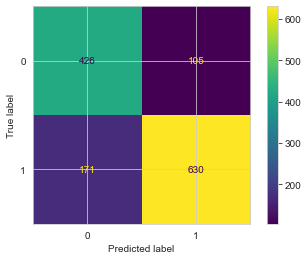

In [8]:
nn_model = keras.models.load_model("LSTM")

lstm_pred_test = nn_model.predict(x_test[:, :, np.newaxis])

print('\nLSTM Classification Report:\n')
inspect.plot_classification_report(y_test,
                                   inspect.continues_to_binary(lstm_pred_test))

# Global Explanation

(3136, 100) (1332, 100)

X_TRAIN Classification Report:

              precision    recall  f1-score   support

         0.0       0.72      0.80      0.76      1303
         1.0       0.84      0.78      0.81      1833

    accuracy                           0.79      3136
   macro avg       0.78      0.79      0.78      3136
weighted avg       0.79      0.79      0.79      3136



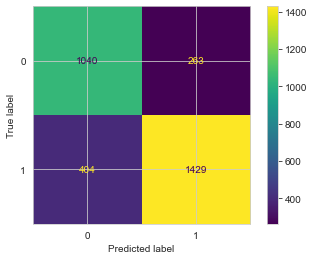


X_Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       597
           1       0.96      0.96      0.96       735

    accuracy                           0.96      1332
   macro avg       0.96      0.96      0.96      1332
weighted avg       0.96      0.96      0.96      1332



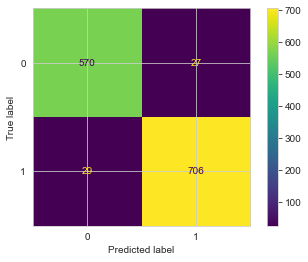

In [9]:
from sklearn.tree import DecisionTreeClassifier

dev_features = explainer.extract_time_series_features(dev_data, "s12", x_train.shape[1])

ts_features_train, ts_features_test, feature_names = dev_features
print(ts_features_train.shape, ts_features_test.shape)

lstm_pred_train = nn_model.predict(x_train[:, :, np.newaxis])

print('\nX_TRAIN Classification Report:\n')
inspect.plot_classification_report(y_train,
                                   inspect.continues_to_binary(lstm_pred_train))

surrogate_dt = DecisionTreeClassifier(random_state=7, max_depth=10)
surrogate_dt.fit(ts_features_train,
                 inspect.continues_to_binary(lstm_pred_train))

surrogate_dt_train_preds = surrogate_dt.predict(ts_features_train)

surrogate_dt_test_preds = surrogate_dt.predict(ts_features_test)
print('\nX_Classification Report:\n')
inspect.plot_classification_report(inspect.continues_to_binary(lstm_pred_test),
                                   surrogate_dt_test_preds)

,importance
mean_19,72.060236
fft_12,13.268635
mean_0,2.876898
mean_17,1.316868
std_16,1.076917
std_7,0.836912
min_9,0.833057
fft_1,0.680803
fft_18,0.641207
std_17,0.527048


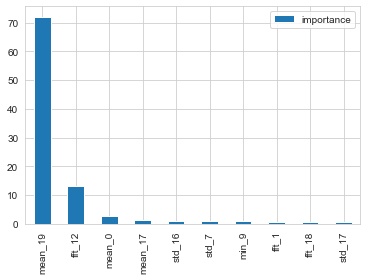

In [10]:
importance = surrogate_dt.feature_importances_
# summarize feature importance
f_imp = pd.DataFrame(importance, columns=["importance"])
f_imp.index = feature_names
f_imp["importance"] = f_imp.importance.values * 100

f_imp=f_imp.sort_values(by=['importance'], ascending=False)
display(f_imp.head(10))
# plot feature importance

f_imp[:10].plot(kind="bar")
plt.show()

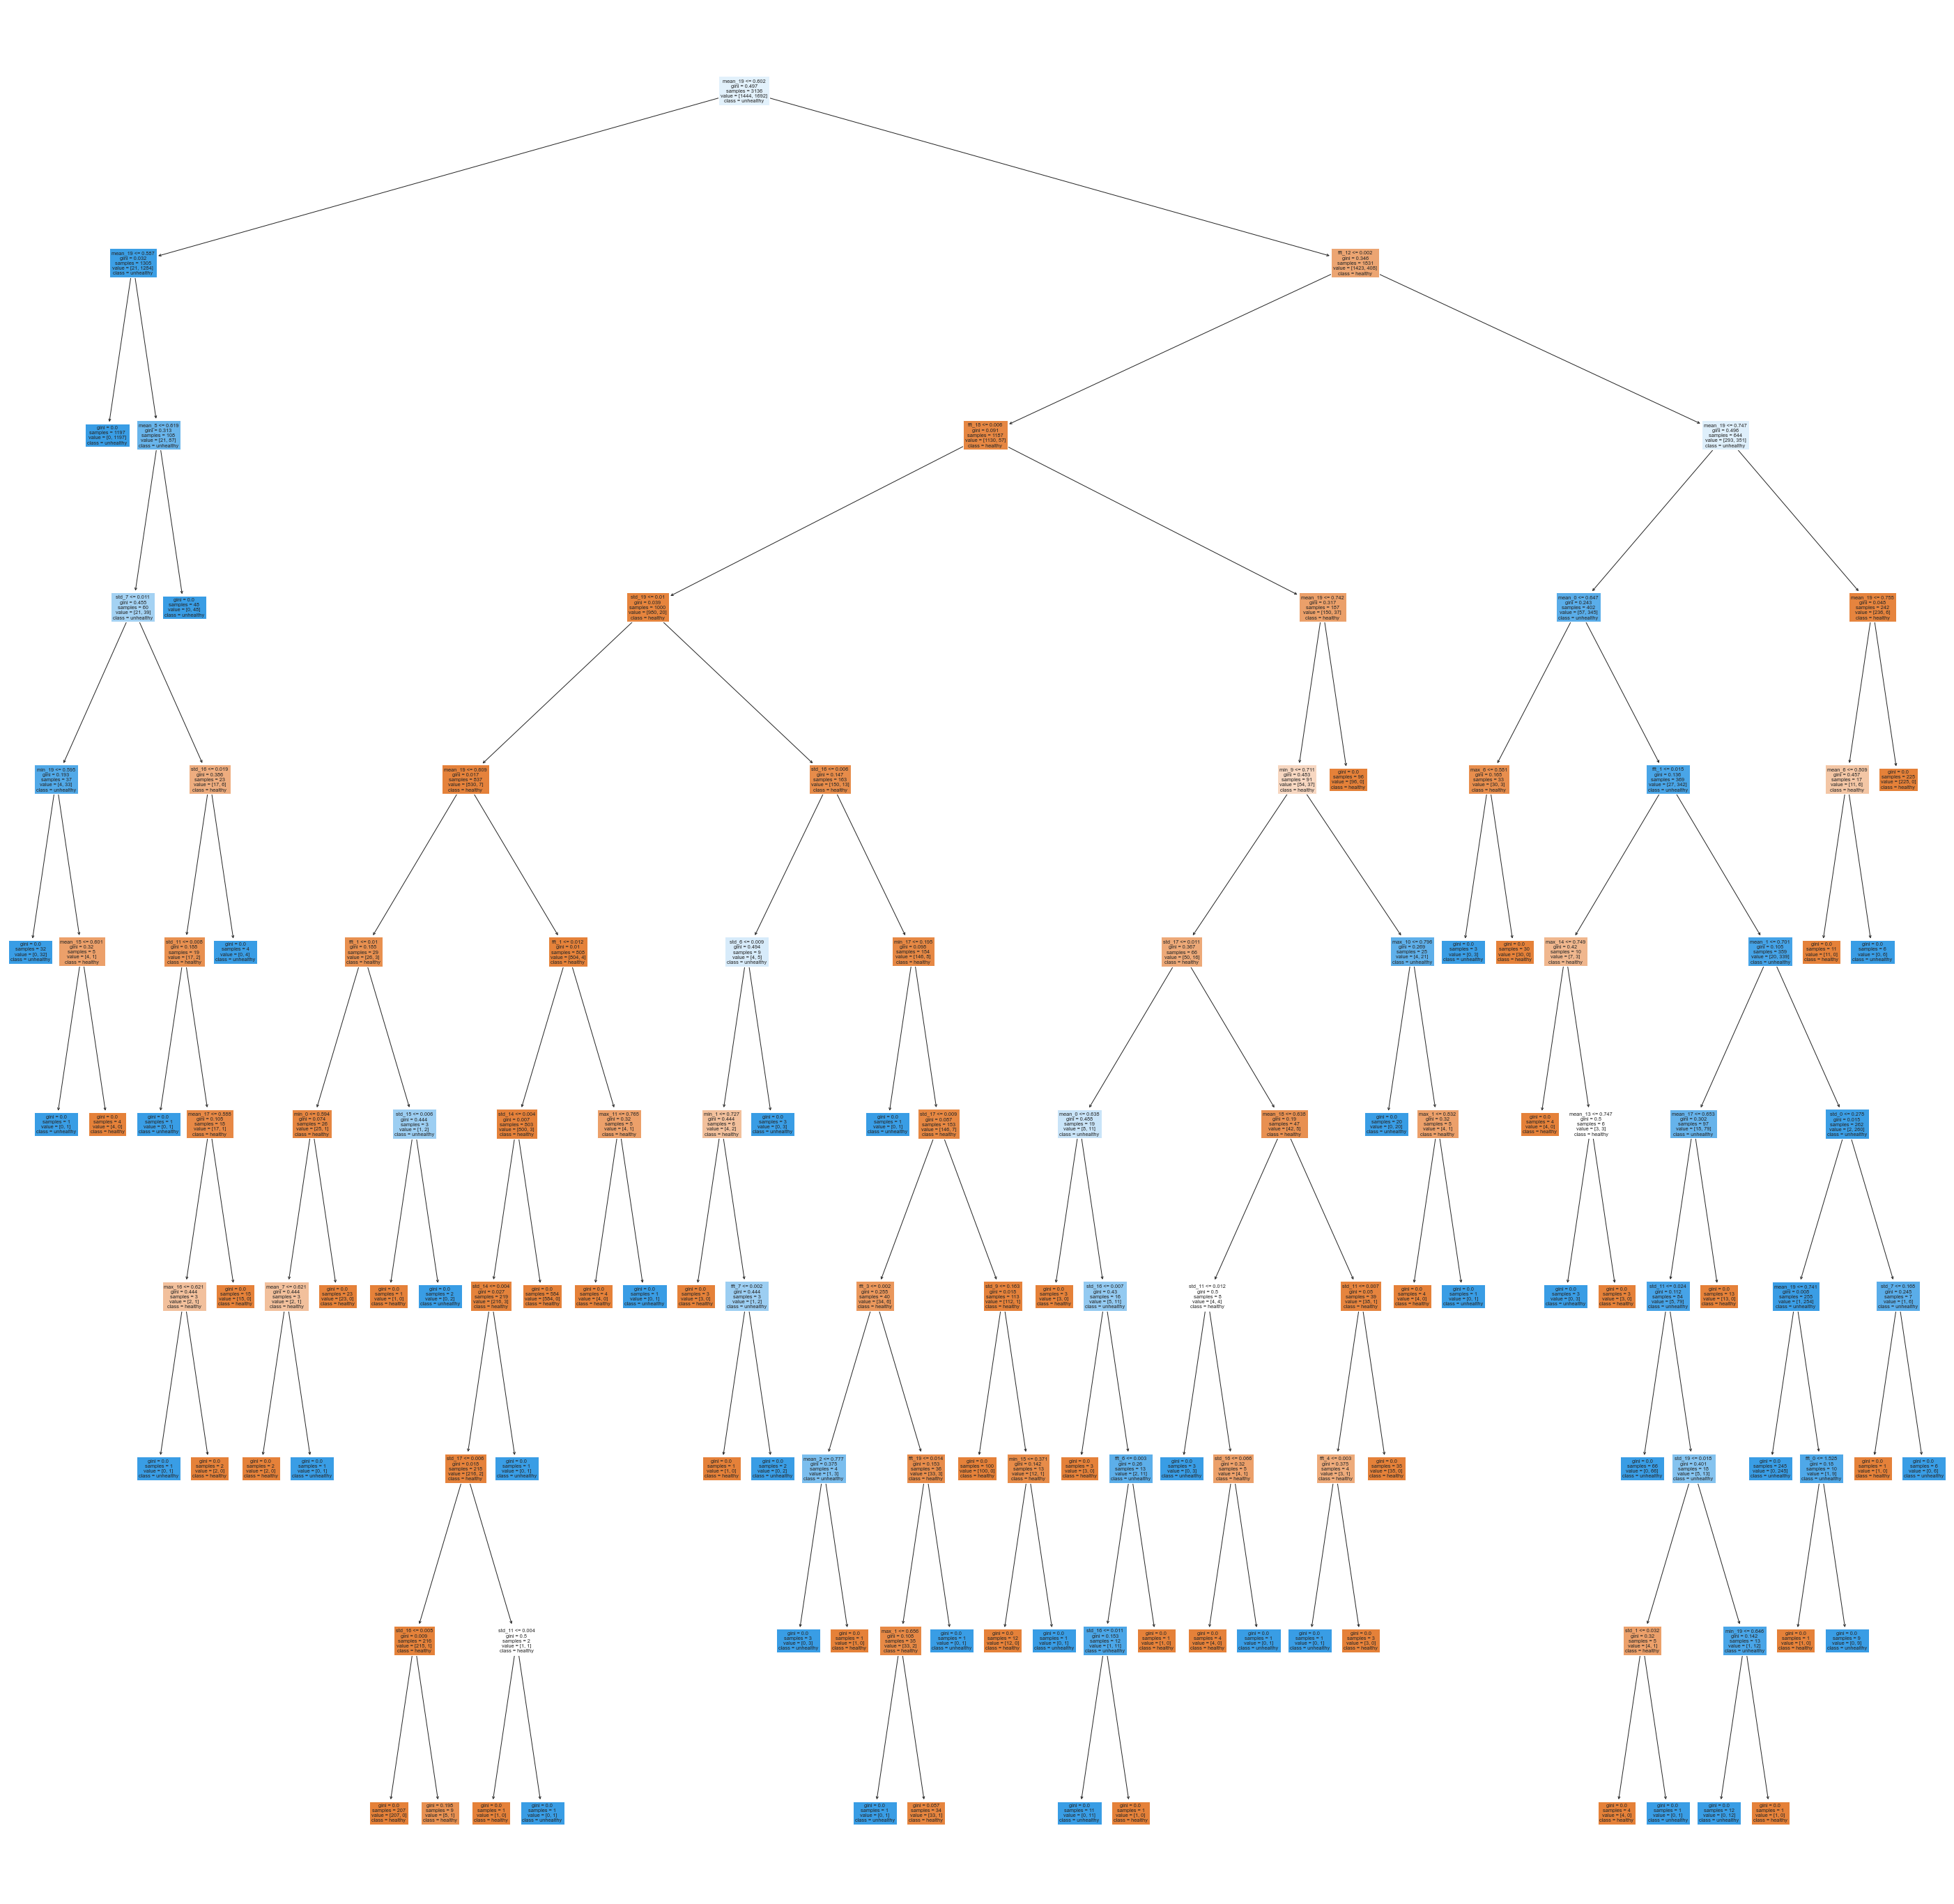

In [11]:
from sklearn import tree

fig = plt.figure(figsize=(50,50))
_ = tree.plot_tree(surrogate_dt, 
                   feature_names=feature_names,  
                   class_names=["healthy", "unhealthy"],
                   filled=True)

# Local Explanations

In [12]:
import warnings
warnings.filterwarnings("ignore")

def load_cluster_models(file_name):
    cluster_df = pd.read_csv("results/{}_df.csv".format(file_name), sep=',')

    with open('results/{}.pkl'.format(file_name), 'rb') as f:
        cluster = pickle.load(f)
    f.close()
    
    return cluster_df, cluster

train_cluster_df, train_cluster = load_cluster_models("train_cluster")

test_df = pd.read_csv("results/test_df.csv", sep=',')
test_engines = test_df.unit.values
test_df = explainer.get_predictions_as_df(x_test, y_test, lstm_pred_test)
test_df["unit"] = test_engines

trainset, testset = cmapss.train_test_split(dev_data)
testset = cmapss.minmax_scale(testset)
testset = cmapss.denoise_sensors(testset)

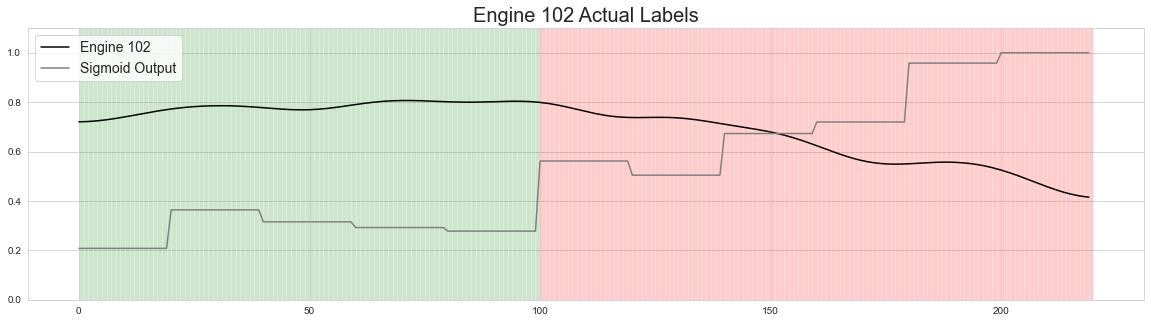

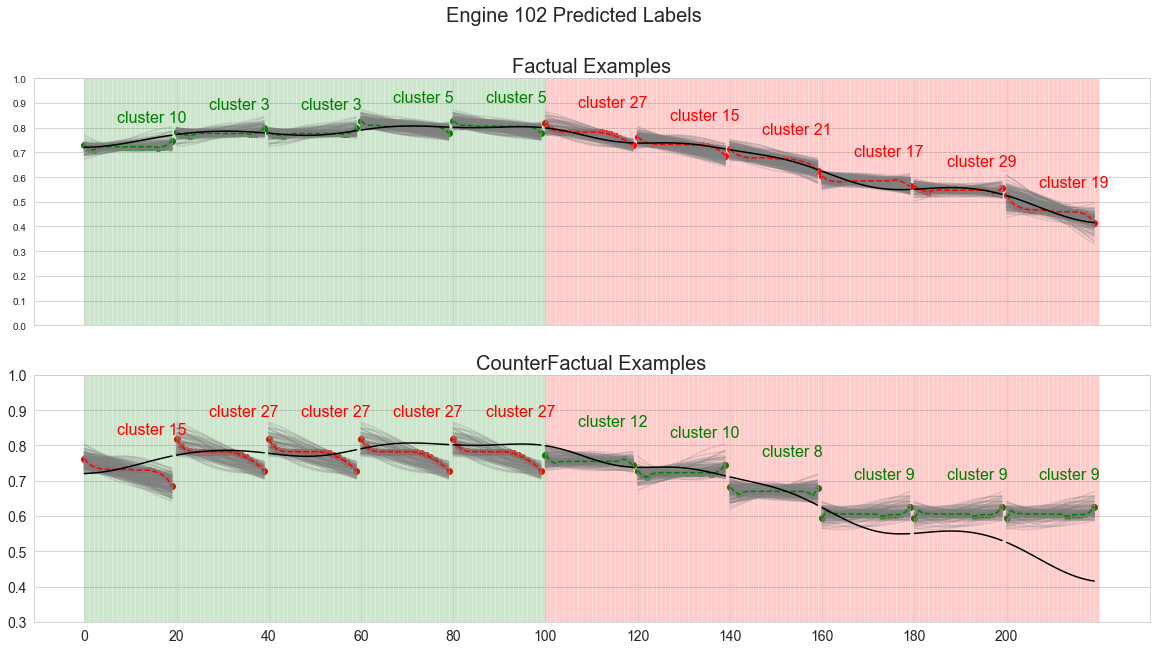

<Figure size 432x288 with 0 Axes>

In [13]:
test_units = list(test_df.unit.unique())
"""[3, 10, 12, 14, 15, 16, 19, 23, 25, 28, 29, 32, 33, 41, 46,
47, 58, 61, 64, 66, 67, 75, 79, 81, 83, 86, 89, 95, 96, 97, 98,
100, 102, 103, 105, 107, 110, 116, 117, 118, 122, 126, 129, 130,
132, 133, 134, 139, 140, 142, 154, 164, 165, 167, 169, 172, 174,
175, 187, 196, 201, 202, 204, 206, 216, 217]
"""

unit = 102 
unit_samples = test_df[test_df.unit==unit].index

engine_explainer_parameters = {"train_cluster": train_cluster,
                               "train_cluster_df": train_cluster_df,
                               "x_test": x_test,
                               "y_test": y_test,
                               "lstm_pred_test": lstm_pred_test}

# first explain the whole engine
explainer.explain_engine(engine_explainer_parameters, unit) #3, 206, 102

In [40]:
def plot_local_counter_and_factuals(train_cluster, train_cluster_df, selected_sample):
    """
    This function receives the train dataframe and a selected sample to 
    visualize the factual and counterfactual example. 
    The train_cluster is a 
    dictionary, which contains the trained clustering model and the 
    train_cluster_df is a dataframe, containing the cluster labels, actual 
    binary labels and the predicted labels with the prediction confidence.

    The function predicts the cluster of the given sample and identifies which
    factual cluster and which counterfactual cluster is the closest to this 
    sample. 

    Input: a dictionary, a dataframe, and one row of a dataframe
    Output: the visualization of the factual and counterfactual clusters 
    of the selected sample 
    """    
    
    from sklearn import tree
    
    # get the selected time series window (sequence) 
    # and exclude y_true, y_pred and model confidence
    x_sample=selected_sample[["ts_{}".format(i) for i in 
                              range(len(selected_sample)-4)]].values

    x_prediction = selected_sample["y_pred"]
    x_actual_label = selected_sample["y_true"]
    x_model_confidence = selected_sample["confidence"]

    # to which healthy cluster from the trainset is this sample the closest?
    closest_healthy_cluster = train_cluster["healthy_clusters"
                                           ]["kmeans"
                                            ].predict(x_sample[np.newaxis, :]
                                                      )[0]

    closest_unhealthy_cluster = train_cluster["unhealthy_clusters"
                                           ]["kmeans"
                                            ].predict(x_sample[np.newaxis, :]
                                                      )[0]
    
    closest_unhealthy_cluster += train_cluster["healthy_clusters"
                                              ]["labels"].max()+1
    
    center_cols = ["center_{}".format(i) for i in range(len(x_sample))]
    
    factual_cluster = None
    counterfactual_cluster = None

    factual_label = None
    counterfactual_label = None

    if int(x_prediction) == 1:
        # assuming your factual cluster is an unhealthy cluster
        factual_cluster = train_cluster_df[
            train_cluster_df.cluster==closest_unhealthy_cluster
        ]

        # and your counterfactual cluster is a healthy cluster
        counterfactual_cluster = train_cluster_df[
                train_cluster_df.cluster==closest_healthy_cluster
            ]
        
        factual_label = closest_unhealthy_cluster
        counterfactual_label = closest_healthy_cluster
    
    # but if the prediction for this sample was healthy
    elif int(x_prediction) == 0:
        # then your factual cluster is a healthy cluster
        factual_cluster = train_cluster_df[
            train_cluster_df.cluster==closest_healthy_cluster
        ]

        # and your counterfactual cluster is an unhealthy cluster
        counterfactual_cluster = train_cluster_df[
            train_cluster_df.cluster==closest_unhealthy_cluster
        ]
        
        factual_label = closest_healthy_cluster
        counterfactual_label = closest_unhealthy_cluster
        
    cluster_labels = (factual_label, counterfactual_label)
    
    
    """ training the local Tree """
    
    # prepare the data
    dev_mode = True 
    dev_data = cmapss.load_data(path)
    dev_data = cmapss.cluster_operational_settings(dev_data,
                                                   dev_mode)
    dev_data = cmapss.calculate_TTF(dev_data)
    dev_data = cmapss.calculate_continues_healthstate(dev_data)
    dev_data = cmapss.calculate_descrete_healthstate(dev_data)
    
    x_train = loadtxt('results/x_train.csv', delimiter=',')
    y_train = loadtxt('results/y_train.csv', delimiter=',')
    x_test = loadtxt('results/x_test.csv', delimiter=',')
    y_test = loadtxt('results/y_test.csv', delimiter=',')
    
    # extract train sets time series features
    dev_features = explainer.extract_time_series_features(dev_data,"s12", x_train.shape[1])
    
    ts_features_train, ts_features_test, feature_names = dev_features

    # now map the ts-features to their clusters
    ts_features_train_df = pd.DataFrame(data=ts_features_train, columns=feature_names)
    
    ts_features_train_df["y_pred"] = train_cluster_df.y_pred.values
    ts_features_train_df["y_true"] = train_cluster_df.y_true.values
    ts_features_train_df["confidence"] = train_cluster_df.confidence.values
    ts_features_train_df["cluster_conf"] = train_cluster_df.cluster_conf.values
    ts_features_train_df["cluster"] = train_cluster_df.cluster.values
    ts_features_train_df["unit"] = train_cluster_df.unit.values
    
   # now get the cluster of the ts-features data#
    factual_indices = ts_features_train_df[
        ts_features_train_df.cluster==factual_label].index

    counterfactual_indices = ts_features_train_df[
        ts_features_train_df.cluster==counterfactual_label].index
    
    # to create a surrogate model, load the nn model & get its predictions for the custer
    nn_model = keras.models.load_model("LSTM")
    lstm_pred_factuals = nn_model.predict(np.array(
        factual_cluster[[col for col in factual_cluster.columns 
                  if col.startswith("ts")]]
    )[:, :, np.newaxis])

    lstm_pred_counterfactuals = nn_model.predict(np.array(
        counterfactual_cluster[[col for col in counterfactual_cluster.columns 
                         if col.startswith("ts")]]
    )[:, :, np.newaxis])

    lstm_clusters_y_pred = np.concatenate((lstm_pred_factuals,
                                          lstm_pred_counterfactuals),
                                         axis=0)
    actual_clusters_y_true = np.concatenate((factual_cluster.y_true,
                                             counterfactual_cluster.y_true),
                                            axis=0)
    
    # now train your local DT
    local_dt = DecisionTreeClassifier(random_state=7, max_depth=5)
    local_dt.fit(ts_features_train[
        np.concatenate((factual_indices, counterfactual_indices), axis=0)],
                     inspect.continues_to_binary(lstm_clusters_y_pred))

    y_preds = local_dt.predict(ts_features_train[
        np.concatenate((factual_indices,
                        counterfactual_indices),
                       axis=0)])
    
    # look at the decision cuts for thess clusters
    #display(explainer.tree_to_code(local_dt, feature_names))
    local_decisions, local_imp_features = tree_to_code(local_dt, feature_names)
    
    # get the features of the selected sample
    features = separate_test_features(selected_sample.name, feature_names, ts_features_test)

#     fig = plt.figure(figsize=(5,5))
#     _ = tree.plot_tree(local_dt, 
#                        feature_names=feature_names,  
#                        class_names=["healthy", "unhealthy"],
#                        filled=True)
    
    def plot_example_cluster(cluster, x_sample, is_unhealthy, is_counterfactual):
        """
        This function receives a cluster, the predicted sample, and a boolean 
        value to assign a color to the cluster subplot (a factual cluster centroid 
        is plotted with green and the centroid of the counterfactual cluster is 
        plotted with red).

        Input: a dataframe, a numpy array, and a boolean value
        Output: subplot of the cluster
        """    
        
        center_color = "green"
        label = "factual"
        if is_unhealthy and is_counterfactual:
            center_color = "red" 
            label="counterfactual"

        elif not is_unhealthy and is_counterfactual:
            center_color = "red"
            label="counterfactual"

        elif is_unhealthy and not is_counterfactual:
            label="factual"
            center_color = "red" 
            
            
        #plot the members of the cluster
        for i in range(len(cluster)):
            m=cluster[[c for c in cluster.columns 
                       if c.startswith("ts_")]].values[i:i+1][0]
            ax.plot(m, c="gray", alpha=0.25)

        # now plot the center of the cluster
        center=cluster[[c for c in cluster.columns 
                        if c.startswith("center_")]
                      ].values[i:i+1][0]
        ax.scatter(range(0, len(center)), center, c=center_color, label=label)
        ax.plot(center, "--", c=center_color)

        # now plot your selected sample
        ax.scatter(range(0, len(x_sample)), x_sample, s=30, c="black",
                   label="predicted_sample")
        ax.plot(x_sample, "--", c="black")

        ax.set_xticks(range(0,len(center)))
        ax.set_yticks(np.arange(0.6, 1, 0.1))
        ax.legend(loc="lower right", fontsize=16)

        # now add the important timesteps
        for f in local_imp_features:
            timestep = int(f.split("_")[1])
            ax.axvspan(xmin=timestep-0.25,
                       xmax=timestep+0.25,
                       ymax=1,
                       facecolor='green', alpha=0.2)

#     if x_model_confidence<50:
#         x_model_confidence = -x_model_confidence + 100
#     else:
    
    fig = plt.figure(figsize=(15,5))
    fig.suptitle(
        "y_true={}  | y_pred={}  |  sigmoid value={}\n\n\n\n\n".format(x_actual_label,
                                                       x_prediction,
                                                       np.round(
                                                           x_model_confidence,2
                                                           )),
                 fontsize=20)


    ax = plt.subplot("121")
    ax.set_title("Factual_Cluster vs Sample",fontsize=16)
    plot_example_cluster(factual_cluster, x_sample, x_prediction, False)

    ax = plt.subplot("122")
    ax.set_title("Counterfactual_Cluster vs Sample", fontsize=16)
    plot_example_cluster(counterfactual_cluster, x_sample, x_prediction, True)

    plt.show()
    tikzplotlib.save("{}.tex".format("counterfactual_sample")) 
    

    # now plot the tree features
    #local_decisions, local_imp_features = tree_to_code(local_dt, feature_names)
    
    fig = plt.figure(figsize=(15,16))
#    fig.suptitle("Time Series Contribution Explanations", fontsize=20)
#     for i in range(len(features.keys())):
#         ax = plt.subplot(3, 1, i+1)
#         values=features[list(features.keys())[i]]
        
#         if list(features.keys())[i] == "fft":
#             drop = values[0]
#             values = [values[1] if x==drop else x for x in values]

#         elif list(features.keys())[i] == "min":
#             drop = values[-1]
#             values = [values[-2] if x==drop else x for x in values]

        
#         ax.set_title("Selected Sample Time-Series Features: {}".format(
#             list(features.keys())[i]),
#                      fontsize=16)
        
#         ax.plot(values,
#                 "--", c="black")
#         ax.set_xticks(range(0,len(values)))
#         ax.set_yticks(np.arange(0, 1.5, 0.1))
        
#         # now add the important timesteps
#         for f in local_imp_features:
#             if f.split("_")[0] in list(features.keys())[i]:
#                 timestep = int(f.split("_")[1])
#                 ax.axvspan(xmin=timestep-0.25,
#                            xmax=timestep+0.25,
#                            ymax=1,
#                            facecolor='green', alpha=0.2)
        

#     # calculate the feature importance for thess clusters
#     importance = local_dt.feature_importances_
#     f_imp = pd.DataFrame(importance, columns=["importance"])
#     f_imp.index = feature_names
#     f_imp["importance"] = f_imp.importance.values * 100
#     f_imp=f_imp.sort_values(by=['importance'], ascending=False)

#     ax = plt.subplot(3, 1, i+2)
    
#     ax.set_title("Feature Impotance", fontsize=16)
#     ax.bar(list(f_imp.head(5).index), height=f_imp.head(5)["importance"])
#     #ax.set_xticks(np.arange(5), list(f_imp.head(5).index))
#     ax.xaxis.set_tick_params(rotation=45)
#     ax.set_yticks(np.arange(0, 105, 5))
    
    ax = plt.subplot(3, 1, 1)#i+3)
    ax.set_title("Decision Cuts", fontsize=20)
    ax.grid(False)
    
    local_decisions = [
        "A sequence is healthy when:",
        "    mean_0 <= 0.7350 & mean_19 > 0.7072 & fft_5 <= 0.001",
        "A sequence becomes unhealthy when fft_5 > 0.0011",
        "",
        "A sequence is healthy when:",
        "    mean_0 > 0.7350 & fft_1 <= 0.0121 & mean_5 <= 0.7386",
        "A sequence becomes unhealthy when mean_5 > 0.7386",
        "",
        "A sequence is healthy when:",
        "    mean_0 > 0.7350 & fft_1 > 0.0121 & std_0 > 0.2782 & fft_3 <= 0.0075",
        "A sequence becomes unhealthy when fft_3 > 0.0075" 
    ]
    
    for j in range(len(local_decisions)):
        ax.text(0.03, j*-0.08 + 0.9, local_decisions[j], fontsize = 20)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #plt.tight_layout()
    tikzplotlib.save("{}.tex".format("explained_sample")) 

    
def tree_to_code(tree, feature_names):
    
    from sklearn.tree import _tree

    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    def recurse(node, depth, decision_cuts, informative_features):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            decision_cuts.append("{}if {} <= {}:".format(
                indent, name, np.round(threshold, 4)))
            informative_features.append(name)
            recurse(tree_.children_left[node], depth + 1, decision_cuts, informative_features)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            decision_cuts.append("{}else:  # if {} > {}".format(
                indent, name, np.round(threshold, 4)))
            informative_features.append(name)
            recurse(tree_.children_right[node], depth + 1, decision_cuts, informative_features)
        else:
            print("{}return {}".format(indent, np.argmax(tree_.value[node][0])))
            decision_cuts.append("{}return {}".format(indent, np.argmax(tree_.value[node][0])))

    local_decision_cuts = [] 
    influencial_features = []
    recurse(0, 1, local_decision_cuts, influencial_features)
    return local_decision_cuts, list(set(influencial_features))


def separate_test_features(index, feature_names, ts_features_test):
    features = {}
    values=[]
    for i in range(len(feature_names)):
        name = feature_names[i].split("_")[0]
        values.append(np.round(ts_features_test[index][i], 4))

        #else: # there is a new name, save what you had and reset the cash
        if len(values)-20==0: # harcoded (window-size)
            features.update({name:values})
            values=[]
            
    del features['mean'] # drop the actual sequence
    return features

Succesfully loaded PHM08 data from ../../Datasets/PHM08_Challenge_Data/train.txt
Succesfully calculated the CTFs (Cycles to Failure).
Succesfully calculated the RULs (Remaining Useful Lives).
Succesfully calculated the Heath States.
  if mean_0 <= 0.735059380531311:
    if mean_19 <= 0.7072096765041351:
      if fft_5 <= 0.0011430191225372255:
        return 0
      else:  # if fft_5 > 0.0011430191225372255
        return 1
    else:  # if mean_19 > 0.7072096765041351
      return 0
  else:  # if mean_0 > 0.735059380531311
    if fft_1 <= 0.012174658011645079:
      if mean_5 <= 0.7386589348316193:
        return 0
      else:  # if mean_5 > 0.7386589348316193
        return 1
    else:  # if fft_1 > 0.012174658011645079
      if std_0 <= 0.278254896402359:
        return 1
      else:  # if std_0 > 0.278254896402359
        if fft_3 <= 0.007598438998684287:
          return 0
        else:  # if fft_3 > 0.007598438998684287
          return 1


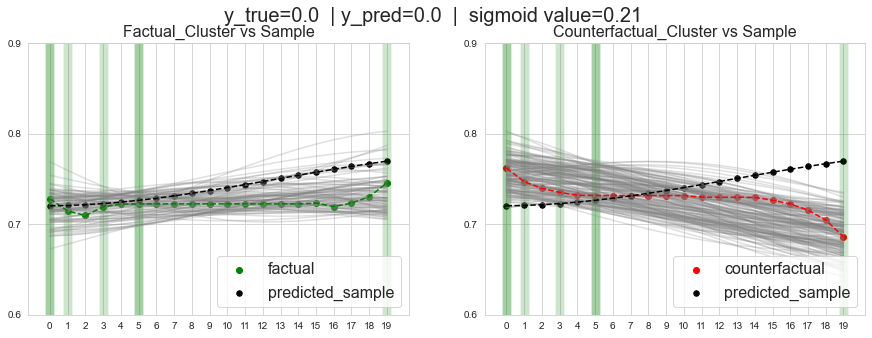

<Figure size 432x288 with 0 Axes>

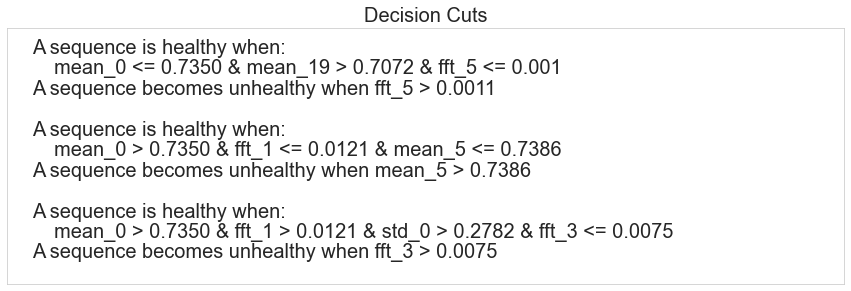

In [41]:
# then explain the sequences of the engine one by one
selected_sample = test_df.iloc[unit_samples[0]]
#explainer.plot_local_counter_and_factuals(train_cluster, train_cluster_df, selected_sample)
plot_local_counter_and_factuals(train_cluster, train_cluster_df, selected_sample)

In [16]:
sigmoid_healthy = [i for i in range(0,-50)]

In [ ]:
confidence_healthy = [i+100 for i in range(-50,0)]

In [ ]:
sigmoid_unhealthy = [i for i in range(50,100)]